# Развёртывание датасета

Импортируем необходимые библиотеки

In [196]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot



from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset

Загружаем данные

In [197]:
dataset = pd.concat(map(lambda file: pd.read_csv(file, usecols=['Issue Date', 'Vehicle Make', 'House Number', 'Street Name', 'Vehicle Year'], 
                    dtype={'Issue Date' : 'object', 'Vehicle Make' : 'object', 'House Number' : 'object', 'Street Name' : 'object', 'Vehicle Year' : 'float64'}, 
                    parse_dates=['Issue Date']), 
                   ['Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv', 
                    'Parking_Violations_Issued_-_Fiscal_Year_2015.csv',
                    'Parking_Violations_Issued_-_Fiscal_Year_2016.csv', 
                    'Parking_Violations_Issued_-_Fiscal_Year_2017.csv']))

Оставляем в датасете только те строки, в которых автомобиль одна из трёх следующих марок: 'DODGE', 'TOYOT', 'HYUND', а дата "происшествия" находится в периоде между 2013-07-7 и 2017-03-10.

In [198]:
dataset = dataset.loc[(dataset['Vehicle Make'].isin(['DODGE', 'TOYOT', 'HYUND'])) & 
                      ((dataset['Issue Date'] >= pd.Timestamp('2013-07-7')) & (dataset['Issue Date'] <= pd.Timestamp('2017-03-10'))) & 
                      ((dataset['Vehicle Year'] >= 1900.0) & (dataset['Vehicle Year'] <= 2015.0))]

In [199]:
dataset.head()

,Issue Date,Vehicle Make,House Number,Street Name,Vehicle Year
8,2013-08-07,TOYOT,100,N.PORTLAND AVE,2001.0
10,2013-07-18,HYUND,NaN,760 BROADWAY BROOKLY,2010.0
11,2013-07-18,TOYOT,NaN,760 BROADWAY BROOKLY,1998.0
16,2013-07-26,TOYOT,145,PROSPECT PKWAY,2010.0
23,2013-07-20,TOYOT,NaN,E/S RIVER TER.,2003.0


In [200]:
dataset.tail()

,Issue Date,Vehicle Make,House Number,Street Name,Vehicle Year
10799283,2016-06-30,TOYOT,NaN,TERMINAL 8 OUTER RDW,2012.0
10799288,2016-06-30,TOYOT,NaN,TERMINAL 7 ARRIVALS,2015.0
10799294,2016-06-30,TOYOT,NaN,F/O OLD TERMINAL 6 J,2007.0
10799299,2016-06-30,TOYOT,1489,WEST AVE,2006.0
10799300,2016-06-30,TOYOT,1551,UNIONPORT RD,2001.0


In [201]:
dataset.set_index('Issue Date',inplace=True)

In [202]:
dataset.head()

,Vehicle Make,House Number,Street Name,Vehicle Year
Issue Date,,,,
2013-08-07,TOYOT,100,N.PORTLAND AVE,2001.0
2013-07-18,HYUND,NaN,760 BROADWAY BROOKLY,2010.0
2013-07-18,TOYOT,NaN,760 BROADWAY BROOKLY,1998.0
2013-07-26,TOYOT,145,PROSPECT PKWAY,2010.0
2013-07-20,TOYOT,NaN,E/S RIVER TER.,2003.0


In [203]:
dataset.tail()

,Vehicle Make,House Number,Street Name,Vehicle Year
Issue Date,,,,
2016-06-30,TOYOT,NaN,TERMINAL 8 OUTER RDW,2012.0
2016-06-30,TOYOT,NaN,TERMINAL 7 ARRIVALS,2015.0
2016-06-30,TOYOT,NaN,F/O OLD TERMINAL 6 J,2007.0
2016-06-30,TOYOT,1489,WEST AVE,2006.0
2016-06-30,TOYOT,1551,UNIONPORT RD,2001.0


In [204]:
dataset.describe()

,Vehicle Year
count,4.928445e+06
mean,2.008461e+03
std,5.253493e+00
min,1.970000e+03
25%,2.005000e+03
50%,2.009000e+03
75%,2.013000e+03
max,2.015000e+03


# Визуализируем датасет

### Проанализируем данные о всех штрафах

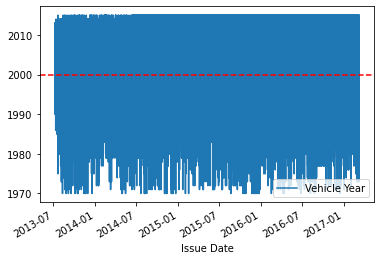

In [205]:
ax = dataset.plot()
ax.axhline(2000, color="red", linestyle="--")

Красная вертикальная линия отделяет штрафы, полученные машинами выпущенные до 2000 года и после.

### Рассмотрим отдельно графики для машин разных марок.

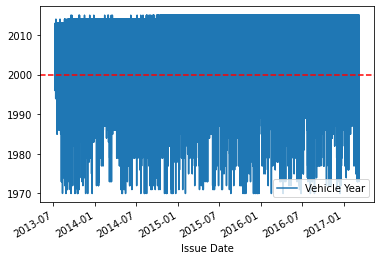

In [206]:
ax = dataset.loc[dataset['Vehicle Make']=='DODGE'].plot()
ax.axhline(2000, color="red", linestyle="--")

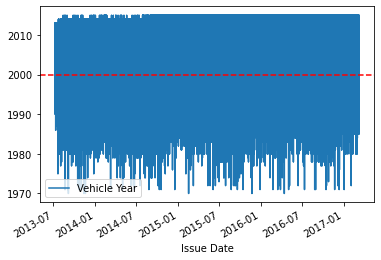

In [207]:
ax = dataset.loc[dataset['Vehicle Make']=='TOYOT'].plot()
ax.axhline(2000, color="red", linestyle="--")

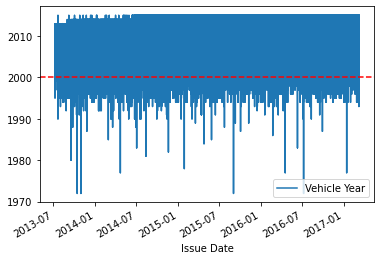

In [208]:
ax = dataset.loc[dataset['Vehicle Make']=='HYUND'].plot()
ax.axhline(2000, color="red", linestyle="--")

Первые два графика не сильно отличаются, но третий выделяется сильнее. Как видно машины марки "Hyundai" намного реже получали штрафы в период с 2017-06, при этом машины, выпущенные до 2000 года, гораздо реже попадали в "неприятности".

### Рассмотрим где чаще всего происходили нарушения

Выведем список улиц, которые находятся в топе по количеству нарушений

In [209]:
dataset['Street Name'].value_counts().head(5)

Broadway                72568
3rd Ave                 46703
5th Ave                 39852
Queens Blvd             30081
HORACE HARDING EXPWY    27081
Name: Street Name, dtype: int64

Выведем для вышеперечисленных улиц номера домов, где чаще всего происходят нарушения

In [210]:
dataset.loc[dataset['Street Name'].isin(dataset['Street Name'].value_counts().head(5).index)].groupby('Street Name')['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,3rd Ave,W,2271
2459,5th Ave,E,1243
4449,Broadway,W,2570
8073,HORACE HARDING EXPWY,221-78,2
8095,Queens Blvd,N,1439


### Рассмотрим результаты отдельно для машин разных марок

#### Dodge

##### До 2000 года

In [211]:
dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5)

Broadway       825
3rd Ave        598
2nd Ave        488
5th Ave        469
Jamaica Ave    463
Name: Street Name, dtype: int64

<AxesSubplot:>

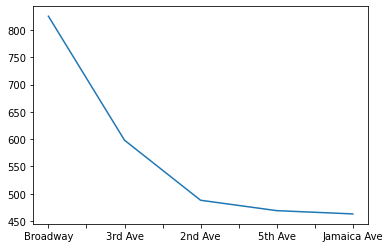

In [212]:
dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5).plot()

In [213]:
dataset.loc[dataset['Street Name'].isin(dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5).index) & (dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] < 2000.0)].groupby('Street Name')['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,2nd Ave,1546,41
160,3rd Ave,W,31
540,5th Ave,E,17
855,Broadway,W,33
1359,Jamaica Ave,216-05,11


##### После 2000 года

In [214]:
dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5)

Broadway         17813
3rd Ave          13563
Madison Ave       9890
5th Ave           8563
Lexington Ave     7491
Name: Street Name, dtype: int64

<AxesSubplot:>

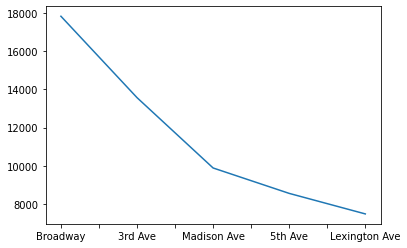

In [215]:
dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5).plot()

In [216]:
dataset.loc[dataset['Street Name'].isin(dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5).index) & (dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] >= 2000.0)].groupby('Street Name')['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,3rd Ave,W,734
1658,5th Ave,E,442
3070,Broadway,W,681
5335,Lexington Ave,E,357
6059,Madison Ave,W,717


#### Toyota

##### До 2000 года

In [217]:
dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5)

Broadway           2808
Jamaica Ave        2165
White Plains Rd    1718
3rd Ave            1708
5th Ave            1661
Name: Street Name, dtype: int64

<AxesSubplot:>

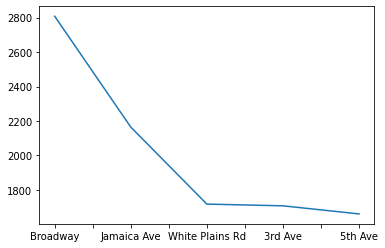

In [218]:
dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5).plot()

In [219]:
dataset.loc[dataset['Street Name'].isin(dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5).index) & (dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] < 2000.0)].groupby('Street Name')['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,3rd Ave,W,68
781,5th Ave,E,42
1550,Broadway,W,106
2711,Jamaica Ave,N,73
3693,White Plains Rd,2901,21


##### После 2000 года

In [220]:
dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5)

Broadway                43574
3rd Ave                 25587
5th Ave                 23807
Queens Blvd             18586
HORACE HARDING EXPWY    17621
Name: Street Name, dtype: int64

<AxesSubplot:>

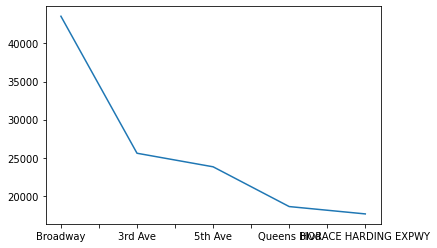

In [221]:
dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5).plot()

In [222]:
dataset.loc[dataset['Street Name'].isin(dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5).index) & (dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] >= 2000.0)].groupby('Street Name')['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,3rd Ave,W,1227
2115,5th Ave,E,605
3911,Broadway,W,1513
7034,HORACE HARDING EXPWY,221-78,2
7047,Queens Blvd,N,905


#### Hyundai

##### До 2000 года

In [223]:
dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5)

Broadway       48
E 31st St      38
37th St        32
115th St       31
Queens Blvd    25
Name: Street Name, dtype: int64

<AxesSubplot:>

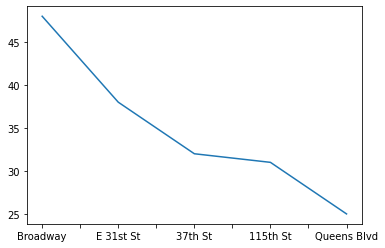

In [224]:
dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5).plot()

In [225]:
dataset.loc[dataset['Street Name'].isin(dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] < 2000.0)]['Street Name'].value_counts().head(5).index) & (dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] < 2000.0)].groupby('Street Name')['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,115th St,89-14,12
6,37th St,25-41,10
19,Broadway,789,3
56,E 31st St,W,19
61,Queens Blvd,N,4


##### После 2000 года

In [226]:
dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5)

Broadway                7500
5th Ave                 5329
3rd Ave                 5228
Queens Blvd             5015
EB HORACE HARDING EX    4658
Name: Street Name, dtype: int64

<AxesSubplot:>

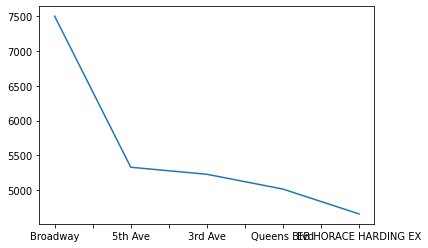

In [227]:
dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5).plot()

In [228]:
dataset.loc[dataset['Street Name'].isin(dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] >= 2000.0)]['Street Name'].value_counts().head(5).index) & (dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] >= 2000.0)].groupby('Street Name')['House Number'].value_counts().rename_axis(['Street Name','House Number']).reset_index(name='freq').drop_duplicates('Street Name')

,Street Name,House Number,freq
0,3rd Ave,W,211
1345,5th Ave,E,132
2530,Broadway,E,245
4361,Queens Blvd,N,238


### Сгруппируем данные по дням и количеству штрафов в этот день

<AxesSubplot:xlabel='Issue Date'>

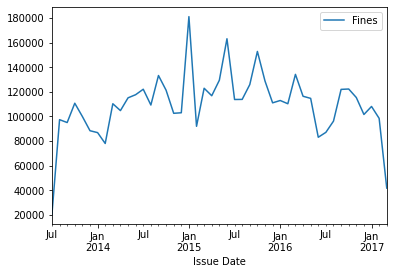

In [229]:
finecount_bydate = pd.DataFrame(dataset.reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'})
finecount_bydate.plot()

In [230]:
finecount_bydate_before2000 = { 'ALL' : pd.DataFrame(dataset.loc[dataset['Vehicle Year'] < 2000.0].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}), 
                                'DODGE' : pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] < 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}), 
                                'TOYOT' : pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] < 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}), 
                                'HYUND' : pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] < 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'})} 
                    
finecount_bydate_after2000 = { 'ALL' : pd.DataFrame(dataset.loc[dataset['Vehicle Year'] >= 2000.0].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}), 
                                'DODGE' : pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='DODGE') & (dataset['Vehicle Year'] >= 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}), 
                                'TOYOT' : pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='TOYOT') & (dataset['Vehicle Year'] >= 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'}), 
                                'HYUND' : pd.DataFrame(dataset.loc[(dataset['Vehicle Make']=='HYUND') & (dataset['Vehicle Year'] >= 2000.0)].reset_index().groupby(['Issue Date'])['Issue Date'].agg('count').groupby(pd.Grouper(freq='M')).agg('sum')).rename(columns={'Issue Date' : 'Fines'})} 

Рассмотрим штрафы машин выпещенных до 2000 года.

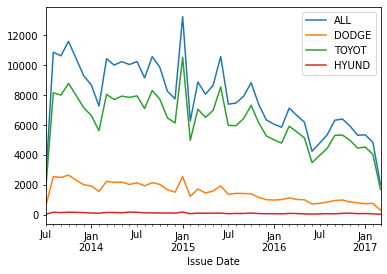

In [231]:
fig, ax = plt.subplots()
finecount_bydate_before2000['ALL'].plot(legend=True, ax=ax)
finecount_bydate_before2000['DODGE'].plot(legend=True, ax=ax)
finecount_bydate_before2000['TOYOT'].plot(legend=True, ax=ax)
finecount_bydate_before2000['HYUND'].plot(legend=True, ax=ax)
plt.legend(['ALL', 'DODGE', 'TOYOT', 'HYUND']);

Как видно на графике, больше всего штрафов получают машины марки "Toyota", затем идут "Dodge, ну и последними, практически с нулем штрафов идут машины марки "Hyundai".

Рассмотрим штрафы машин выпещенных после 2000 года.

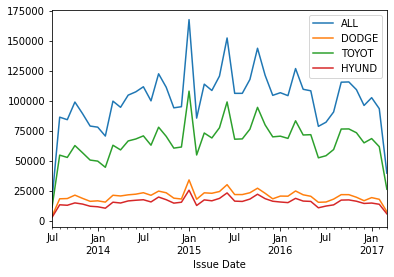

In [232]:
fig, ax = plt.subplots()
finecount_bydate_after2000['ALL'].plot(legend=True, ax=ax)
finecount_bydate_after2000['DODGE'].plot(legend=True, ax=ax)
finecount_bydate_after2000['TOYOT'].plot(legend=True, ax=ax)
finecount_bydate_after2000['HYUND'].plot(legend=True, ax=ax)
plt.legend(['ALL', 'DODGE', 'TOYOT', 'HYUND']);

Здесь ситуация не сильно изменилась, единственное: машины марки "Hyundai" получили гораздно больше штрафов, практически столько же, сколько и машины марки "Dodge".

In [233]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

### Дифференциация

In [234]:
adfuller_test(finecount_bydate['Fines'])

ADF Test Statistic : -5.539144647285208
p-value : 1.7174215997300394e-06
#Lags Used : 0
Number of Observations Used : 44
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Посмотрим как меняется количество штрафов каждый месяц

In [235]:
finecount_bydate['Fines First Difference'] = finecount_bydate['Fines'] - finecount_bydate['Fines'].shift(1)
finecount_bydate.head()

,Fines,Fines First Difference
Issue Date,,
2013-07-31,20374,NaN
2013-08-31,97301,76927.0
2013-09-30,94959,-2342.0
2013-10-31,110644,15685.0
2013-11-30,99855,-10789.0


Посмотрим как меняется количество штрафов каждый год

In [236]:
finecount_bydate['Seasonal First Difference']=finecount_bydate['Fines']-finecount_bydate['Fines'].shift(12)
finecount_bydate.head(20)

,Fines,Fines First Difference,Seasonal First Difference
Issue Date,,,
2013-07-31,20374,NaN,NaN
2013-08-31,97301,76927.0,NaN
2013-09-30,94959,-2342.0,NaN
2013-10-31,110644,15685.0,NaN
2013-11-30,99855,-10789.0,NaN
2013-12-31,88307,-11548.0,NaN
2014-01-31,86766,-1541.0,NaN
2014-02-28,77942,-8824.0,NaN
2014-03-31,110237,32295.0,NaN


In [237]:
adfuller_test(finecount_bydate['Seasonal First Difference'].dropna())

ADF Test Statistic : -0.3955160885063703
p-value : 0.9108447424312499
#Lags Used : 8
Number of Observations Used : 24
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<AxesSubplot:xlabel='Issue Date'>

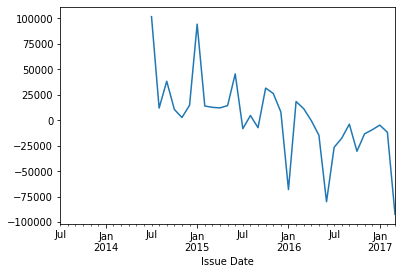

In [238]:
finecount_bydate['Seasonal First Difference'].plot()

#### Посмотрим как меняется количество штрафов каждый год для разных марок машин

##### До 2000 года

###### Dodge

In [239]:
adfuller_test(finecount_bydate_before2000['DODGE']['Fines'])

ADF Test Statistic : -0.7872626881959429
p-value : 0.8228349541789248
#Lags Used : 3
Number of Observations Used : 41
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [240]:
finecount_bydate_before2000['DODGE']['Fines First Difference'] = finecount_bydate_before2000['DODGE']['Fines'] - finecount_bydate_before2000['DODGE']['Fines'].shift(1)
finecount_bydate_before2000['DODGE'].head()

,Fines,Fines First Difference
Issue Date,,
2013-07-31,548,NaN
2013-08-31,2549,2001.0
2013-09-30,2491,-58.0
2013-10-31,2650,159.0
2013-11-30,2309,-341.0


In [241]:
finecount_bydate_before2000['DODGE']['Seasonal First Difference']=finecount_bydate_before2000['DODGE']['Fines']-finecount_bydate_before2000['DODGE']['Fines'].shift(12)
finecount_bydate_before2000['DODGE'].head(20)

,Fines,Fines First Difference,Seasonal First Difference
Issue Date,,,
2013-07-31,548,NaN,NaN
2013-08-31,2549,2001.0,NaN
2013-09-30,2491,-58.0,NaN
2013-10-31,2650,159.0,NaN
2013-11-30,2309,-341.0,NaN
2013-12-31,2005,-304.0,NaN
2014-01-31,1926,-79.0,NaN
2014-02-28,1555,-371.0,NaN
2014-03-31,2232,677.0,NaN


In [242]:
adfuller_test(finecount_bydate_before2000['DODGE']['Seasonal First Difference'].dropna())

ADF Test Statistic : -8.1340742386856
p-value : 1.0708704308401971e-12
#Lags Used : 0
Number of Observations Used : 32
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Issue Date'>

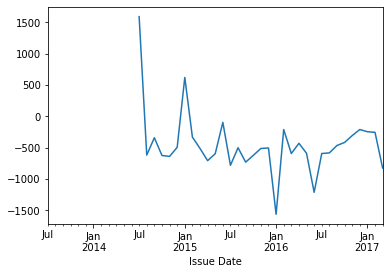

In [243]:
finecount_bydate_before2000['DODGE']['Seasonal First Difference'].plot()

###### Toyota

In [244]:
adfuller_test(finecount_bydate_before2000['TOYOT']['Fines'])

ADF Test Statistic : 0.08982949185204288
p-value : 0.9653598069371531
#Lags Used : 4
Number of Observations Used : 40
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [245]:
finecount_bydate_before2000['TOYOT']['Fines First Difference'] = finecount_bydate_before2000['TOYOT']['Fines'] - finecount_bydate_before2000['TOYOT']['Fines'].shift(1)
finecount_bydate_before2000['TOYOT'].head()

,Fines,Fines First Difference
Issue Date,,
2013-07-31,1663,NaN
2013-08-31,8162,6499.0
2013-09-30,8008,-154.0
2013-10-31,8786,778.0
2013-11-30,7984,-802.0


In [246]:
finecount_bydate_before2000['TOYOT']['Seasonal First Difference']=finecount_bydate_before2000['TOYOT']['Fines']-finecount_bydate_before2000['TOYOT']['Fines'].shift(12)
finecount_bydate_before2000['TOYOT'].head(20)

,Fines,Fines First Difference,Seasonal First Difference
Issue Date,,,
2013-07-31,1663,NaN,NaN
2013-08-31,8162,6499.0,NaN
2013-09-30,8008,-154.0,NaN
2013-10-31,8786,778.0,NaN
2013-11-30,7984,-802.0,NaN
2013-12-31,7159,-825.0,NaN
2014-01-31,6638,-521.0,NaN
2014-02-28,5624,-1014.0,NaN
2014-03-31,8058,2434.0,NaN


In [247]:
adfuller_test(finecount_bydate_before2000['TOYOT']['Seasonal First Difference'].dropna())

ADF Test Statistic : -6.584520623978227
p-value : 7.371672833564615e-09
#Lags Used : 0
Number of Observations Used : 32
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Issue Date'>

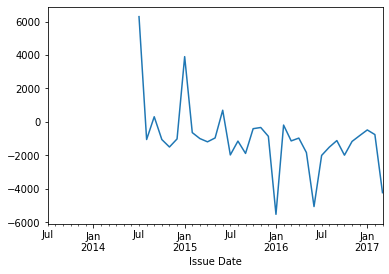

In [248]:
finecount_bydate_before2000['TOYOT']['Seasonal First Difference'].plot()

###### Hyundai

In [249]:
adfuller_test(finecount_bydate_before2000['HYUND']['Fines'])

ADF Test Statistic : -1.4916425719384432
p-value : 0.5376415134829555
#Lags Used : 1
Number of Observations Used : 43
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [250]:
finecount_bydate_before2000['HYUND']['Fines First Difference'] = finecount_bydate_before2000['HYUND']['Fines'] - finecount_bydate_before2000['HYUND']['Fines'].shift(1)
finecount_bydate_before2000['HYUND'].head()

,Fines,Fines First Difference
Issue Date,,
2013-07-31,32,NaN
2013-08-31,164,132.0
2013-09-30,139,-25.0
2013-10-31,166,27.0
2013-11-30,157,-9.0


In [251]:
finecount_bydate_before2000['HYUND']['Seasonal First Difference']=finecount_bydate_before2000['HYUND']['Fines']-finecount_bydate_before2000['HYUND']['Fines'].shift(12)
finecount_bydate_before2000['HYUND'].head(20)

,Fines,Fines First Difference,Seasonal First Difference
Issue Date,,,
2013-07-31,32,NaN,NaN
2013-08-31,164,132.0,NaN
2013-09-30,139,-25.0,NaN
2013-10-31,166,27.0,NaN
2013-11-30,157,-9.0,NaN
2013-12-31,137,-20.0,NaN
2014-01-31,112,-25.0,NaN
2014-02-28,94,-18.0,NaN
2014-03-31,149,55.0,NaN


In [252]:
adfuller_test(finecount_bydate_before2000['HYUND']['Seasonal First Difference'].dropna())

ADF Test Statistic : -6.478665247492668
p-value : 1.311636822120921e-08
#Lags Used : 0
Number of Observations Used : 32
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Issue Date'>

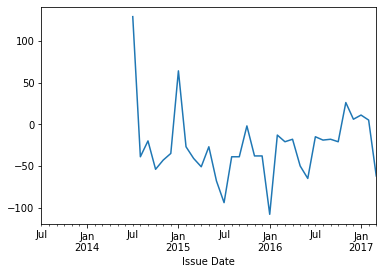

In [253]:
finecount_bydate_before2000['HYUND']['Seasonal First Difference'].plot()

##### После 2000 года

###### Dodge

In [254]:
adfuller_test(finecount_bydate_after2000['DODGE']['Fines'])

ADF Test Statistic : -5.44759306592022
p-value : 2.688805210425275e-06
#Lags Used : 0
Number of Observations Used : 44
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [255]:
finecount_bydate_after2000['DODGE']['Fines First Difference'] = finecount_bydate_after2000['DODGE']['Fines'] - finecount_bydate_after2000['DODGE']['Fines'].shift(1)
finecount_bydate_after2000['DODGE'].head()

,Fines,Fines First Difference
Issue Date,,
2013-07-31,3840,NaN
2013-08-31,18338,14498.0
2013-09-30,18537,199.0
2013-10-31,21389,2852.0
2013-11-30,18704,-2685.0


In [256]:
finecount_bydate_after2000['DODGE']['Seasonal First Difference']=finecount_bydate_after2000['DODGE']['Fines']-finecount_bydate_after2000['DODGE']['Fines'].shift(12)
finecount_bydate_after2000['DODGE'].head(20)

,Fines,Fines First Difference,Seasonal First Difference
Issue Date,,,
2013-07-31,3840,NaN,NaN
2013-08-31,18338,14498.0,NaN
2013-09-30,18537,199.0,NaN
2013-10-31,21389,2852.0,NaN
2013-11-30,18704,-2685.0,NaN
2013-12-31,16237,-2467.0,NaN
2014-01-31,16643,406.0,NaN
2014-02-28,15563,-1080.0,NaN
2014-03-31,21291,5728.0,NaN


In [257]:
adfuller_test(finecount_bydate_after2000['DODGE']['Seasonal First Difference'].dropna())

ADF Test Statistic : -0.6048010972508961
p-value : 0.8698934809668712
#Lags Used : 8
Number of Observations Used : 24
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<AxesSubplot:xlabel='Issue Date'>

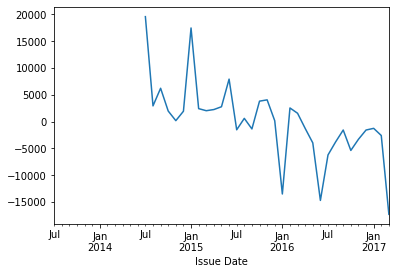

In [258]:
finecount_bydate_after2000['DODGE']['Seasonal First Difference'].plot()

###### Toyota

In [259]:
adfuller_test(finecount_bydate_after2000['TOYOT']['Fines'])

ADF Test Statistic : -5.281936222279805
p-value : 5.967676895018006e-06
#Lags Used : 0
Number of Observations Used : 44
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [260]:
finecount_bydate_after2000['TOYOT']['Fines First Difference'] = finecount_bydate_after2000['TOYOT']['Fines'] - finecount_bydate_after2000['TOYOT']['Fines'].shift(1)
finecount_bydate_after2000['TOYOT'].head()

,Fines,Fines First Difference
Issue Date,,
2013-07-31,11401,NaN
2013-08-31,54756,43355.0
2013-09-30,52839,-1917.0
2013-10-31,62747,9908.0
2013-11-30,56761,-5986.0


In [261]:
finecount_bydate_after2000['TOYOT']['Seasonal First Difference']=finecount_bydate_after2000['TOYOT']['Fines']-finecount_bydate_after2000['TOYOT']['Fines'].shift(12)
finecount_bydate_after2000['TOYOT'].head(20)

,Fines,Fines First Difference,Seasonal First Difference
Issue Date,,,
2013-07-31,11401,NaN,NaN
2013-08-31,54756,43355.0,NaN
2013-09-30,52839,-1917.0,NaN
2013-10-31,62747,9908.0,NaN
2013-11-30,56761,-5986.0,NaN
2013-12-31,50629,-6132.0,NaN
2014-01-31,49758,-871.0,NaN
2014-02-28,44613,-5145.0,NaN
2014-03-31,63006,18393.0,NaN


In [262]:
adfuller_test(finecount_bydate_after2000['TOYOT']['Seasonal First Difference'].dropna())

ADF Test Statistic : -0.011989939801070815
p-value : 0.9575292228984691
#Lags Used : 8
Number of Observations Used : 24
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<AxesSubplot:xlabel='Issue Date'>

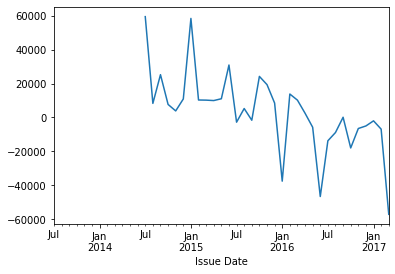

In [263]:
finecount_bydate_after2000['TOYOT']['Seasonal First Difference'].plot()

###### Hyundai

In [264]:
adfuller_test(finecount_bydate_after2000['HYUND']['Fines'])

ADF Test Statistic : -5.087657071794104
p-value : 1.4842672267244952e-05
#Lags Used : 0
Number of Observations Used : 44
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [265]:
finecount_bydate_after2000['HYUND']['Fines First Difference'] = finecount_bydate_after2000['HYUND']['Fines'] - finecount_bydate_after2000['HYUND']['Fines'].shift(1)
finecount_bydate_after2000['HYUND'].head()

,Fines,Fines First Difference
Issue Date,,
2013-07-31,2890,NaN
2013-08-31,13332,10442.0
2013-09-30,12945,-387.0
2013-10-31,14906,1961.0
2013-11-30,13940,-966.0


In [266]:
finecount_bydate_after2000['HYUND']['Seasonal First Difference']=finecount_bydate_after2000['HYUND']['Fines']-finecount_bydate_after2000['HYUND']['Fines'].shift(12)
finecount_bydate_after2000['HYUND'].head(20)

,Fines,Fines First Difference,Seasonal First Difference
Issue Date,,,
2013-07-31,2890,NaN,NaN
2013-08-31,13332,10442.0,NaN
2013-09-30,12945,-387.0,NaN
2013-10-31,14906,1961.0,NaN
2013-11-30,13940,-966.0,NaN
2013-12-31,12140,-1800.0,NaN
2014-01-31,11689,-451.0,NaN
2014-02-28,10493,-1196.0,NaN
2014-03-31,15501,5008.0,NaN


In [267]:
adfuller_test(finecount_bydate_after2000['HYUND']['Seasonal First Difference'].dropna())

ADF Test Statistic : -0.754367217977247
p-value : 0.8321603790866721
#Lags Used : 8
Number of Observations Used : 24
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<AxesSubplot:xlabel='Issue Date'>

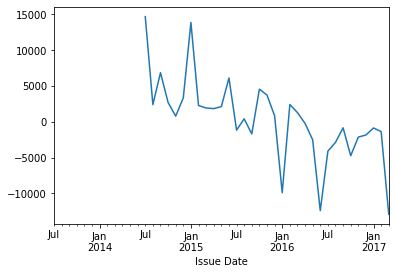

In [268]:
finecount_bydate_after2000['HYUND']['Seasonal First Difference'].plot()

Как видно выше, большинство машин получают примерно одинаковое количество штрафов, независимо от марки и года выпуска. При этом большая часть приведенных выше марок получали меньше штрафов в период с 2014-02 по 2015-04 (январь - апрель) по сравнении за предыдущий год. В период с 2015-04 по 2015-06 количество штрафов было практически таким же как и год назад. В иной период, у таких марок как Dodge (До 2000 года) и Toyota (До 2000 года) количество штрафов увеличилось, но не сильно по сравнению с предыдущим годом, у Dodge(После 2000 года) и Hyundai (После 2000 года) количество штрафов увеличилось сильнее по сравнению с предыдущим годом, а у Toyota (После 2000 года) прибавилось довольно много штрафов по сравнению с предыдущем годом. В остальной период времени у всех марок количество штрафов не сильно колеблилось. У Hyundai (До 2000 года) было примерно одним и тем же на протяжении всего периода.

### Авторегрессионная модель

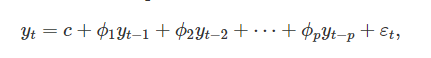

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

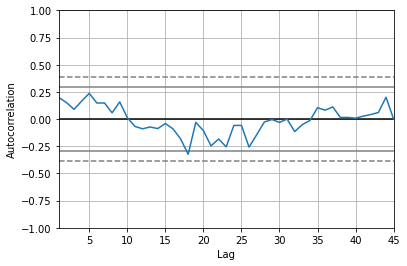

In [269]:
autocorrelation_plot(finecount_bydate['Fines'])

C:\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


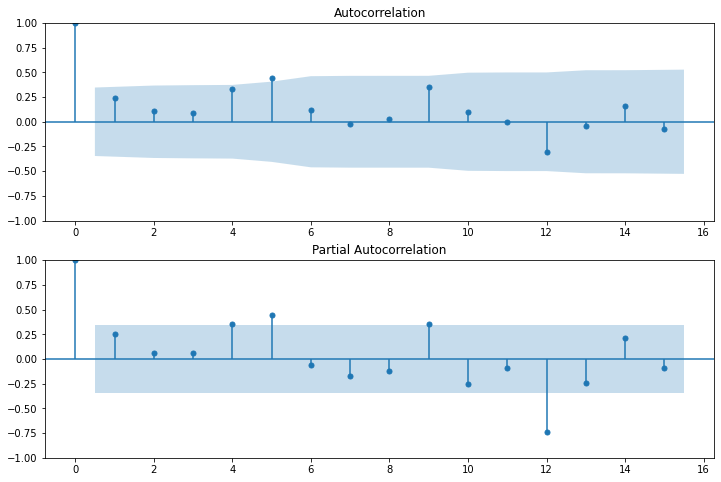

In [286]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(finecount_bydate['Seasonal First Difference'].iloc[13:],lags=15,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(finecount_bydate['Seasonal First Difference'].iloc[13:],lags=15,ax=ax2)

In [271]:
model=sm.tsa.arima.ARIMA(finecount_bydate['Fines'],order=(1,1,1))
model_fit=model.fit()

In [272]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Fines   No. Observations:                   45
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -511.374
Date:                Thu, 21 Apr 2022   AIC                           1028.748
Time:                        06:22:20   BIC                           1034.100
Sample:                    07-31-2013   HQIC                          1030.733
                         - 03-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2295      0.276      0.831      0.406      -0.312       0.771
ma.L1         -0.6919      0.267     -2.590      0.010      -1.215      -0.168
sigma2      5.375e+08   5.11e-10   1.05e+18      0.000    5.38e+08    5.38e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 6.72
Prob(Q):                              0.93   Prob(JB):                         0.03
Heteroskedasticity (H):               0.60   Skew:                             0.42
Prob(H) (two-sided):                  0.33   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.3e+33. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Issue Date'>

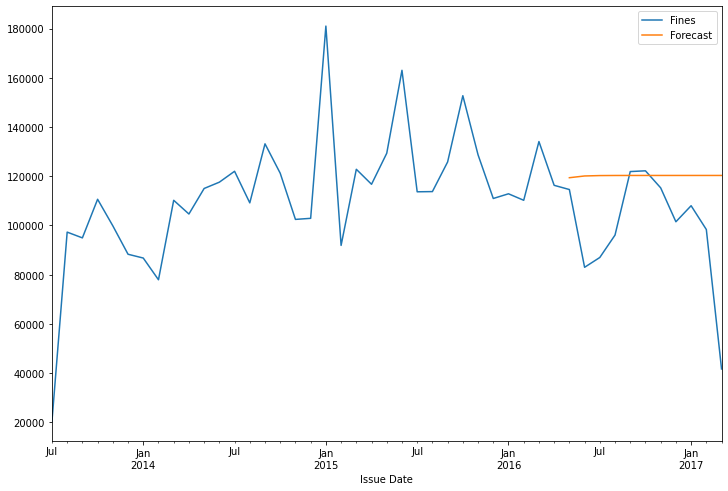

In [283]:
finecount_bydate['Forecast']=model_fit.predict(start=34,end=44,dynamic=True)
finecount_bydate[['Fines','Forecast']].plot(figsize=(12,8))

In [274]:
model=sm.tsa.statespace.SARIMAX(finecount_bydate['Fines'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<AxesSubplot:xlabel='Issue Date'>

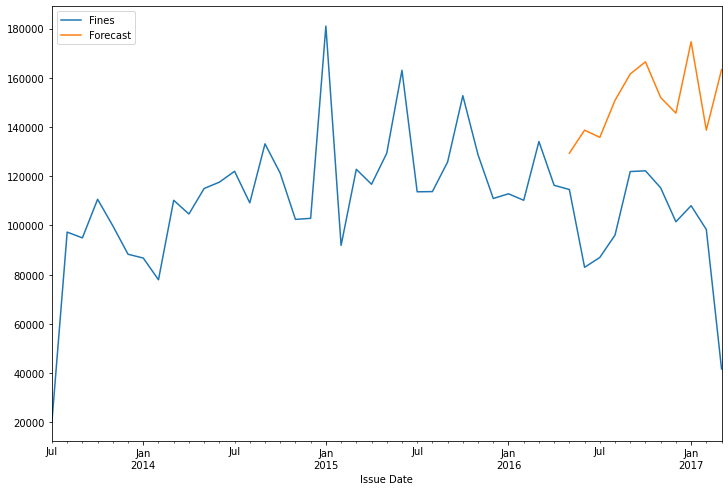

In [284]:
finecount_bydate['Forecast']=results.predict(start=34,end=44,dynamic=True)
finecount_bydate[['Fines','Forecast']].plot(figsize=(12,8))

In [276]:
future_dates=[finecount_bydate.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [277]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=finecount_bydate.columns)

In [278]:
future_datest_df.tail()

,Fines,Fines First Difference,Seasonal First Difference,Forecast
2018-10-31,NaN,NaN,NaN,NaN
2018-11-30,NaN,NaN,NaN,NaN
2018-12-31,NaN,NaN,NaN,NaN
2019-01-31,NaN,NaN,NaN,NaN
2019-02-28,NaN,NaN,NaN,NaN


In [279]:
future_df=pd.concat([finecount_bydate,future_datest_df])

<AxesSubplot:>

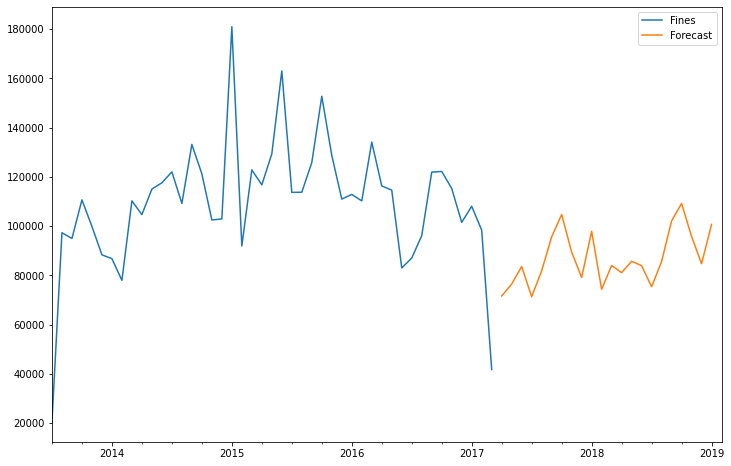

In [287]:
future_df['Forecast'] = results.predict(start = 45, end = 66, dynamic= True)  
future_df[['Fines', 'Forecast']].plot(figsize=(12, 8))